
# Seasonal Biogeochemical Model using CO2SYS in Python

This notebook replicates a biogeochemical box model originally implemented in R. It uses Python along with the [CO2SYS](https://pypi.org/project/pyco2sys/) toolbox for carbonate chemistry calculations. The model simulates the seasonal variability of temperature, salinity, DIC, TA, pCO₂, and pH in surface and deep ocean layers.

## Directory Structure
- `img/`: Saved plots
- `data/raw/`: Raw input data
- `data/interim/`: Intermediate results
- `data/processed/`: Final outputs (CSV, NetCDF, etc.)


In [1]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

In [62]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from pathlib import Path
import PyCO2SYS as pyco2

sns.set(style="whitegrid")

In [ ]:

# Model parameters
params = {
    'tau_1T': 0.14, 'tau_1S': 0.11, 'tau_2': 0.19,
    'A_1T': 14.48, 'A_1S': -1.46, 'A_2T': 5.21,
    'phi_1T': -0.63, 'phi_1S': np.pi / 4, 'phi_2T': np.pi / 2,
    'T1_star': 15, 'T2_star': 10,
    'S1_star': 35, 'S2_star': 34,
    'h1': 50, 'h2': 100,
    'KD': 0.1, 'NCP': 0.02, 'PICPOC': 0.04, 'Remin': 0.9,
    'K_air': 0.02, 'alpha_CO2': 0.01, 'pCO2_atm': 423.57
}

# Initial state variables: [T1, T2, S1, S2, DIC1, DIC2, TA1, TA2]
state0 = [15, 10, 35, 34, 2000, 2100, 2300, 2400]

# Time points (daily over 10 years)
times = np.arange(0, 365 * 10, 10)



In [51]:

def model(state, t, p):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state
    
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t / 365 + p['phi_1T'])
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t / 365 + p['phi_2T'])
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t / 365 + p['phi_1S'])

    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2']
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    J_air = 0  # placeholder – real J_air is added later using pyco2sys

    dDIC1 = (J_air + p['KD'] * (DIC2 - DIC1) / p['h1'] - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    #dDIC1 = (p['K_air'] * p['alpha_CO2'] * (p['pCO2_atm'] - DIC1) + p['KD'] * (DIC2 - DIC1) / p['h1'] - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    dDIC2 = (p['Remin'] * p['NCP'] * (1 + p['PICPOC']) - p['KD'] * (DIC2 - DIC1) / p['h2']) / p['h2']
    dTA1 = (p['KD'] * (TA2 - TA1) / p['h1'] - 2 * p['NCP'] * p['PICPOC']) / p['h1']
    dTA2 = (-p['KD'] * (TA2 - TA1) / p['h2'] + 2 * p['NCP'] * p['PICPOC']) / p['h2']

    # --- Mixing step based on potential density ---
    # Simplified density approximation: ρ ≈ ρ₀ - α(T - T₀) + β(S - S₀)
    # We'll use constants: α = 0.2, β = 0.8 (approx), ρ₀ = 1025 kg/m³
    alpha = 0.2 # For every degree increase in T, density decreases by ~0.2
    beta = 0.8 # For every unit increase in S, density increases by ~0.8
    rho1 = 1025 - alpha * (T1 - 10) + beta * (S1 - 35)
    rho2 = 1025 - alpha * (T2 - 10) + beta * (S2 - 35)

    if rho1 > rho2: #If rho1 > rho2 → surface water is heavier, mixing occurs.
        h1 = p['h1']
        h2 = p['h2']
        mix_T = (h1 * T1 + h2 * T2) / (h1 + h2)
        mix_S = (h1 * S1 + h2 * S2) / (h1 + h2)
        T1 = T2 = mix_T
        S1 = S2 = mix_S
        #DIC1 = DIC2 = (h1 * DIC1 + h2 * DIC2) / (h1 + h2)
        #TA1 = TA2 = (h1 * TA1 + h2 * TA2) / (h1 + h2)

    return [dT1, dT2, dS1, dS2, dDIC1, dDIC2, dTA1, dTA2]


In [ ]:

output = odeint(model, state0, times, args=(params,))
output_df = pd.DataFrame(output, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df['time'] = times

In [53]:
print(output_df.head())

          T1         T2         S1    S2         DIC1         DIC2  \
0  15.000000  10.000000  35.000000  34.0  2000.000000  2100.000000   
1   2.026920  10.875639  35.842536  34.0  2000.035831  2099.991874   
2   1.116933  11.742435  35.625841  34.0  2000.071645  2099.983753   
3   0.617327  12.557725  35.390645  34.0  2000.107441  2099.975636   
4   0.542869  13.297409  35.143902  34.0  2000.143219  2099.967523   

           TA1          TA2  time  
0  2300.000000  2400.000000     0  
1  2300.039670  2399.990162    10  
2  2300.079320  2399.980330    20  
3  2300.118951  2399.970502    30  
4  2300.158562  2399.960680    40  


In [54]:
# Loop through each time step to calculate carbonate chemistry
for i in range(len(output_df)):
    try:
        # --- Surface carbonate chemistry ---
        res_surface = pyco2.sys(
            par1=output_df.loc[i, 'TA1'], # already in μmol·kg⁻¹
            par2=output_df.loc[i, 'DIC1'], # already in μmol·kg⁻¹
            par1_type=1,  # TA
            par2_type=2,  # DIC
            salinity=output_df.loc[i, 'S1'],
            temperature=output_df.loc[i, 'T1'],
            pressure=1,
            opt_pH_scale=1
        )

        pCO2_surface = res_surface['pCO2']
        output_df.loc[i, 'pH_surface'] = res_surface['pH_total']
        output_df.loc[i, 'pCO2_surface'] = pCO2_surface

        # --- J_air calculation ---
        J_air = params['K_air'] * params['alpha_CO2'] * (params['pCO2_atm'] - pCO2_surface)
        output_df.loc[i, 'J_air'] = J_air

        # --- Recalculate dDIC1 using actual J_air ---
        DIC1 = output_df.loc[i, 'DIC1']
        DIC2 = output_df.loc[i, 'DIC2']

        dDIC1_recalc = (J_air + params['KD'] * (DIC2 - DIC1) / params['h1']- params['NCP'] * (1 + params['PICPOC'])) / params['h1']
        output_df.loc[i, 'dDIC1_recalc'] = dDIC1_recalc

        dDIC2_recalc = (params['Remin'] * params['NCP'] * (1 + params['PICPOC'])- params['KD'] * (DIC2 - DIC1) / params['h2']) / params['h2']
        output_df.loc[i, 'dDIC2_recalc'] = dDIC2_recalc


        # --- Deep carbonate chemistry ---
        res_deep = pyco2.sys(
            par1=output_df.loc[i, 'TA2'],
            par2=output_df.loc[i, 'DIC2'],
            par1_type=1,
            par2_type=2,
            salinity=output_df.loc[i, 'S2'],
            temperature=output_df.loc[i, 'T2'],
            pressure=100,
            opt_pH_scale=1
        )
        output_df.loc[i, 'pH_deep'] = res_deep['pH_total']
        output_df.loc[i, 'pCO2_deep'] = res_deep['pCO2']

    except Exception as e:
        print(f"Error on row {i}: {e}")
        continue

# Save updated output
output_df.to_csv(processedDir + "output_df_with_co2sys2.csv", index=False)

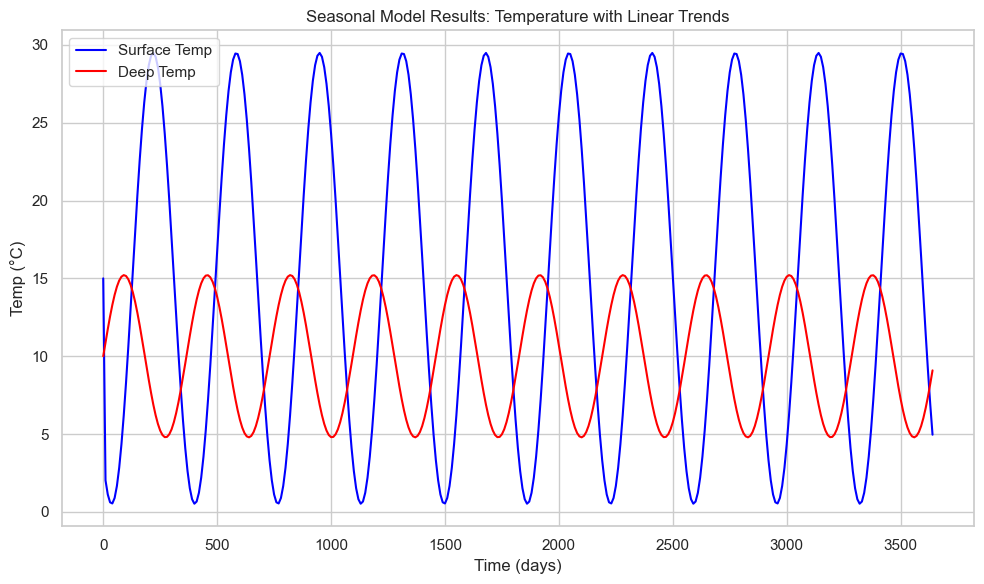

In [55]:
# Plot original temperature data
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['T1'], label='Surface Temp', color='blue')
plt.plot(output_df['time'], output_df['T2'], label='Deep Temp', color='red')

# Labels and styling
plt.xlabel("Time (days)")
plt.ylabel("Temp (°C)")
plt.title("Seasonal Model Results: Temperature with Linear Trends")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "temperature_plot2.png", dpi=300)
plt.show()


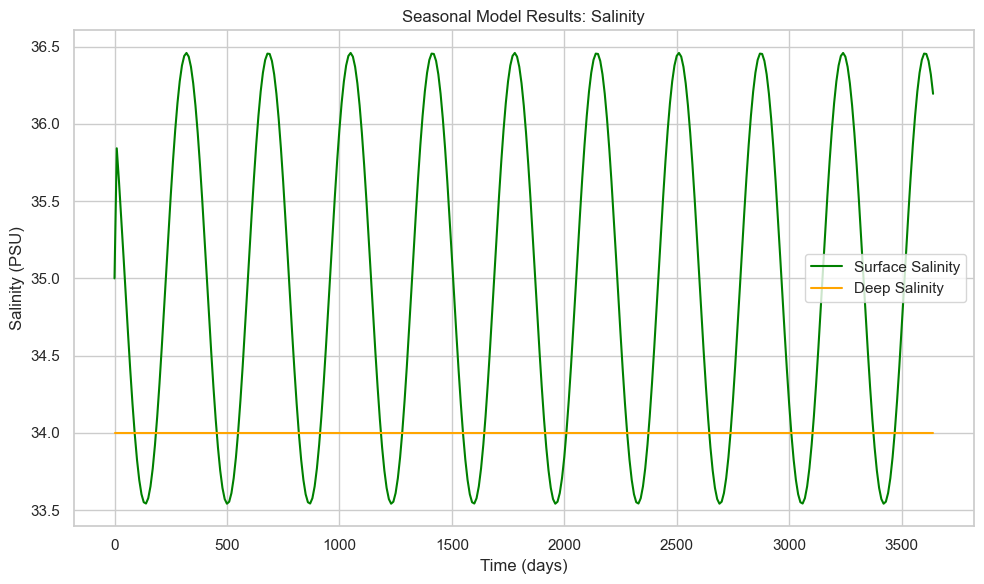

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['S1'], label='Surface Salinity', color='green')
plt.plot(output_df['time'], output_df['S2'], label='Deep Salinity', color='orange')
plt.xlabel("Time (days)")
plt.ylabel("Salinity (PSU)")
plt.title("Seasonal Model Results: Salinity")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "salinity_plot2.png", dpi=300)
plt.show()


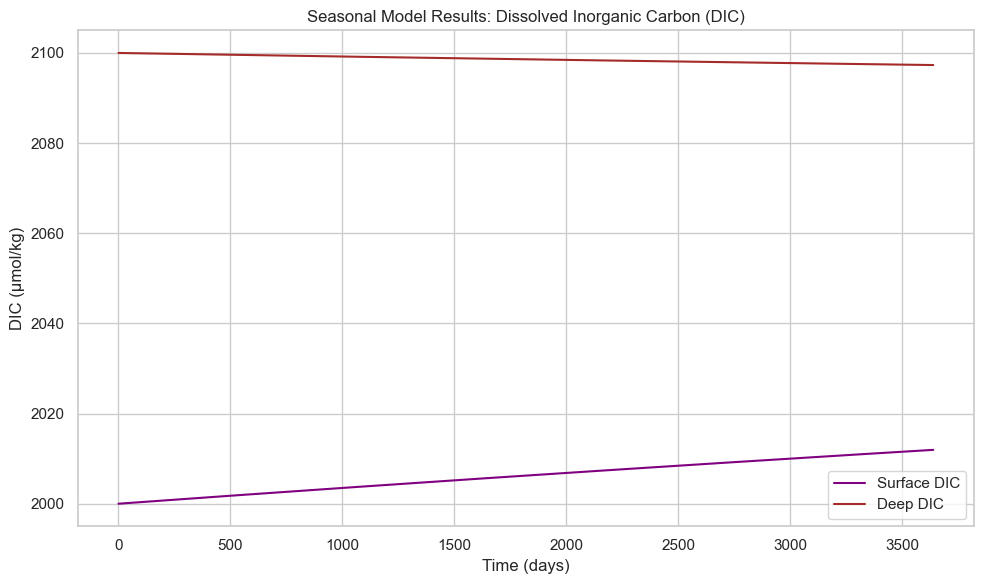

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['DIC1'], label='Surface DIC', color='purple')
plt.plot(output_df['time'], output_df['DIC2'], label='Deep DIC', color='brown')
plt.xlabel("Time (days)")
plt.ylabel("DIC (μmol/kg)")
plt.title("Seasonal Model Results: Dissolved Inorganic Carbon (DIC)")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "dic_plot2.png", dpi=300)
plt.show()


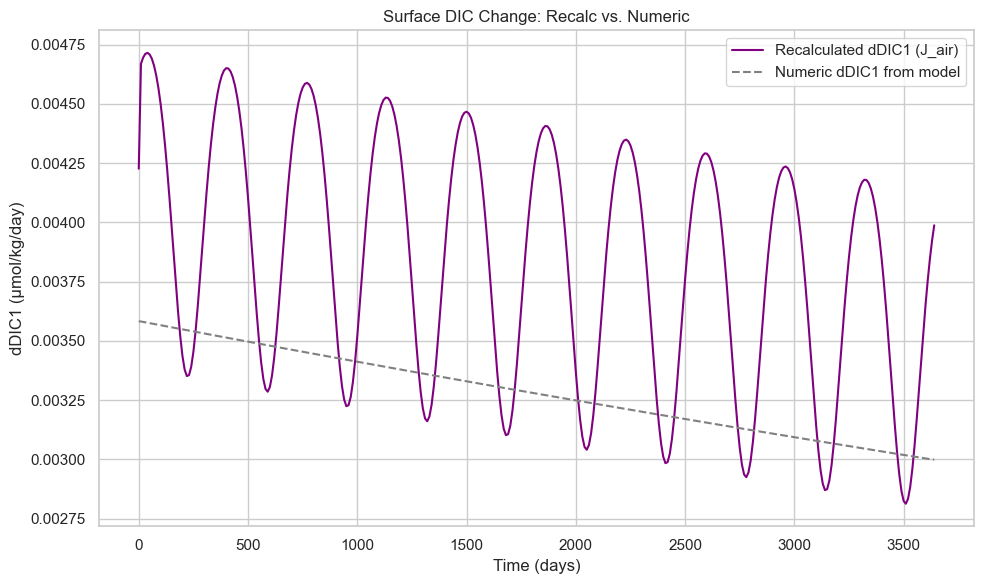

In [61]:
output_df['dDIC1_numeric'] = np.gradient(output_df['DIC1'], output_df['time'])

plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['dDIC1_recalc'], label='Recalculated dDIC1 (J_air)', color='purple')
plt.plot(output_df['time'], output_df['dDIC1_numeric'], label='Numeric dDIC1 from model', linestyle='--', color='gray')
plt.xlabel('Time (days)')
plt.ylabel('dDIC1 (µmol/kg/day)')
plt.title('Surface DIC Change: Recalc vs. Numeric')
plt.legend()
plt.tight_layout()
plt.show()


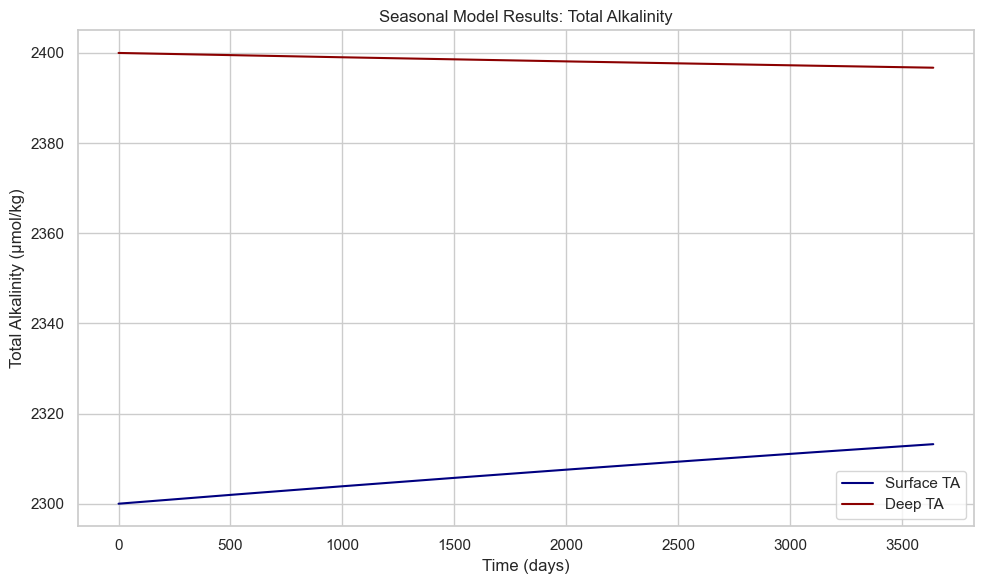

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['TA1'], label='Surface TA', color='navy')
plt.plot(output_df['time'], output_df['TA2'], label='Deep TA', color='darkred')
plt.xlabel("Time (days)")
plt.ylabel("Total Alkalinity (μmol/kg)")
plt.title("Seasonal Model Results: Total Alkalinity")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "alkalinity_plot2.png", dpi=300)
plt.show()


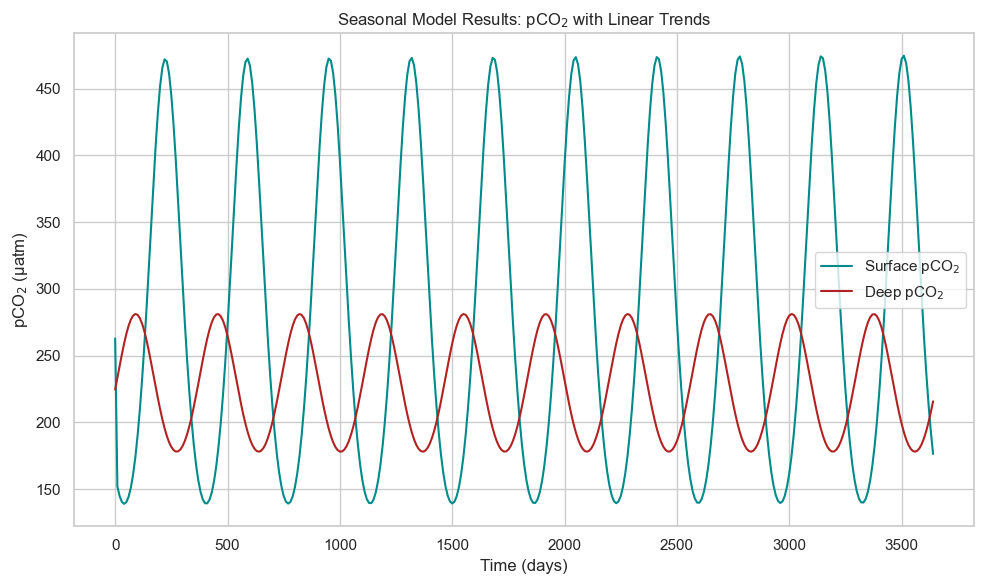

In [59]:
# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['pCO2_surface'], label='Surface pCO$_2$', color='darkcyan')
plt.plot(output_df['time'], output_df['pCO2_deep'], label='Deep pCO$_2$', color='firebrick')

# Labels and styling
plt.xlabel("Time (days)")
plt.ylabel("pCO$_2$ (µatm)")
plt.title("Seasonal Model Results: pCO$_2$ with Linear Trends")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "pco2_plot2.png", dpi=300)
plt.show()

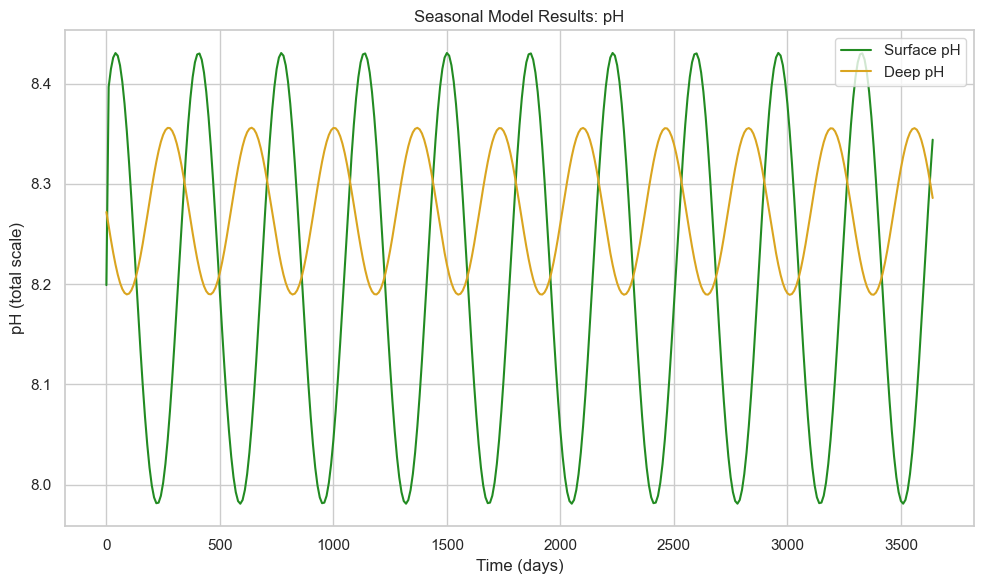

In [60]:

plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['pH_surface'], label='Surface pH', color='forestgreen')
plt.plot(output_df['time'], output_df['pH_deep'], label='Deep pH', color='goldenrod')

# Labels and styling
plt.xlabel("Time (days)")
plt.ylabel("pH (total scale)")
plt.title("Seasonal Model Results: pH")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "ph_plot2.png", dpi=300)
plt.show()


In [63]:

def model_oneway(state, t, p):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state
    
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t / 365 + p['phi_1T'])
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t / 365 + p['phi_2T'])
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t / 365 + p['phi_1S'])

    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2']
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    J_air = 0  # placeholder – real J_air is added later using pyco2sys

    dDIC1 = (J_air + p['KD'] * (DIC2 - DIC1) / p['h1'] - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    #dDIC1 = (p['K_air'] * p['alpha_CO2'] * (p['pCO2_atm'] - DIC1) + p['KD'] * (DIC2 - DIC1) / p['h1'] - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    dDIC2 = (p['Remin'] * p['NCP'] * (1 + p['PICPOC']) - p['KD'] * (DIC2 - DIC1) / p['h2']) / p['h2']
    dTA1 = (p['KD'] * (TA2 - TA1) / p['h1'] - 2 * p['NCP'] * p['PICPOC']) / p['h1']
    dTA2 = (-p['KD'] * (TA2 - TA1) / p['h2'] + 2 * p['NCP'] * p['PICPOC']) / p['h2']

    # --- Mixing step based on potential density ---
    # Simplified density approximation: ρ ≈ ρ₀ - α(T - T₀) + β(S - S₀)
    # We'll use constants: α = 0.2, β = 0.8 (approx), ρ₀ = 1025 kg/m³
    alpha = 0.2 # For every degree increase in T, density decreases by ~0.2
    beta = 0.8 # For every unit increase in S, density increases by ~0.8
    rho1 = 1025 - alpha * (T1 - 10) + beta * (S1 - 35)
    rho2 = 1025 - alpha * (T2 - 10) + beta * (S2 - 35)

    if rho1 > rho2: #If rho1 > rho2 → surface water is heavier, mixing occurs.
        h1 = p['h1']
        h2 = p['h2']
        mix_T = (h1 * T1 + h2 * T2) / (h1 + h2)
        mix_S = (h1 * S1 + h2 * S2) / (h1 + h2)
        T1 = T2 = mix_T
        S1 = S2 = mix_S
        #DIC1 = DIC2 = (h1 * DIC1 + h2 * DIC2) / (h1 + h2)
        #TA1 = TA2 = (h1 * TA1 + h2 * TA2) / (h1 + h2)

    return [dT1, dT2, dS1, dS2, dDIC1, dDIC2, dTA1, dTA2]


In [64]:
# Run model
output_1 = odeint(model_oneway, state0, times, args=(params,))
output_df_1 = pd.DataFrame(output_1, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df_1['time'] = times

In [65]:
pCO2_surface, pH_surface = [], []
pCO2_deep, pH_deep = [], []
J_air_list = []

for i in range(len(output_df_1)):
    # --- Surface ---
    res_surface = pyco2.sys(
        par1=output_df_1.loc[i, 'TA1'],
        par2=output_df_1.loc[i, 'DIC1'],
        par1_type=1, par2_type=2,
        salinity=output_df_1.loc[i, 'S1'],
        temperature=output_df_1.loc[i, 'T1'],
        pressure=1,
        opt_pH_scale=1
    )
    pCO2_surf = res_surface['pCO2']
    pH_surf = res_surface['pH_total']
    J_air = params['K_air'] * params['alpha_CO2'] * (params['pCO2_atm'] - pCO2_surf)

    # --- Deep ---
    res_deep = pyco2.sys(
        par1=output_df_1.loc[i, 'TA2'],
        par2=output_df_1.loc[i, 'DIC2'],
        par1_type=1, par2_type=2,
        salinity=output_df_1.loc[i, 'S2'],
        temperature=output_df_1.loc[i, 'T2'],
        pressure=100,
        opt_pH_scale=1
    )
    pCO2_d = res_deep['pCO2']
    pH_d = res_deep['pH_total']

    # Store results
    pCO2_surface.append(pCO2_surf)
    pH_surface.append(pH_surf)
    J_air_list.append(J_air)
    pCO2_deep.append(pCO2_d)
    pH_deep.append(pH_d)

output_df_1['pCO2_surface'] = pCO2_surface
output_df_1['pH_surface'] = pH_surface
output_df_1['J_air'] = J_air_list
output_df_1['pCO2_deep'] = pCO2_deep
output_df_1['pH_deep'] = pH_deep


In [66]:
J_air_interp = interp1d(output_df_1['time'], output_df_1['J_air'], kind='linear', fill_value='extrapolate')

In [67]:
def model_feedback(state, t, p):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state
    J_air = J_air_interp(t)

    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t / 365 + p['phi_1T'])
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t / 365 + p['phi_2T'])
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t / 365 + p['phi_1S'])

    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2']
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    dDIC1 = (J_air + p['KD'] * (DIC2 - DIC1) / p['h1'] - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    dDIC2 = (p['Remin'] * p['NCP'] * (1 + p['PICPOC']) - p['KD'] * (DIC2 - DIC1) / p['h2']) / p['h2']
    dTA1 = (p['KD'] * (TA2 - TA1) / p['h1'] - 2 * p['NCP'] * p['PICPOC']) / p['h1']
    dTA2 = (-p['KD'] * (TA2 - TA1) / p['h2'] + 2 * p['NCP'] * p['PICPOC']) / p['h2']

    return [dT1, dT2, dS1, dS2, dDIC1, dDIC2, dTA1, dTA2]


In [68]:
output_2 = odeint(model_feedback, state0, times, args=(params,))
output_df_2 = pd.DataFrame(output_2, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df_2['time'] = times


In [69]:
pCO2_surf_final, pH_surf_final = [], []
pCO2_deep_final, pH_deep_final = [], []

for i in range(len(output_df_2)):
    # --- Surface ---
    res_surface = pyco2.sys(
        par1=output_df_2.loc[i, 'TA1'],
        par2=output_df_2.loc[i, 'DIC1'],
        par1_type=1, par2_type=2,
        salinity=output_df_2.loc[i, 'S1'],
        temperature=output_df_2.loc[i, 'T1'],
        pressure=1,
        opt_pH_scale=1
    )
    pCO2_surf_final.append(res_surface['pCO2'])
    pH_surf_final.append(res_surface['pH_total'])

    # --- Deep ---
    res_deep = pyco2.sys(
        par1=output_df_2.loc[i, 'TA2'],
        par2=output_df_2.loc[i, 'DIC2'],
        par1_type=1, par2_type=2,
        salinity=output_df_2.loc[i, 'S2'],
        temperature=output_df_2.loc[i, 'T2'],
        pressure=100,
        opt_pH_scale=1
    )
    pCO2_deep_final.append(res_deep['pCO2'])
    pH_deep_final.append(res_deep['pH_total'])

# Store in DataFrame
output_df_2['pCO2_surface'] = pCO2_surf_final
output_df_2['pH_surface'] = pH_surf_final
output_df_2['pCO2_deep'] = pCO2_deep_final
output_df_2['pH_deep'] = pH_deep_final


In [82]:
# Merge on 'time', adding suffixes to distinguish runs
merged_df = output_df_1.merge(
    output_df_2,
    on='time',
    suffixes=('_run1', '_run2')
)
# Save to CSV
merged_df.to_csv(processedDir + "merged_model_runs.csv", index=False)

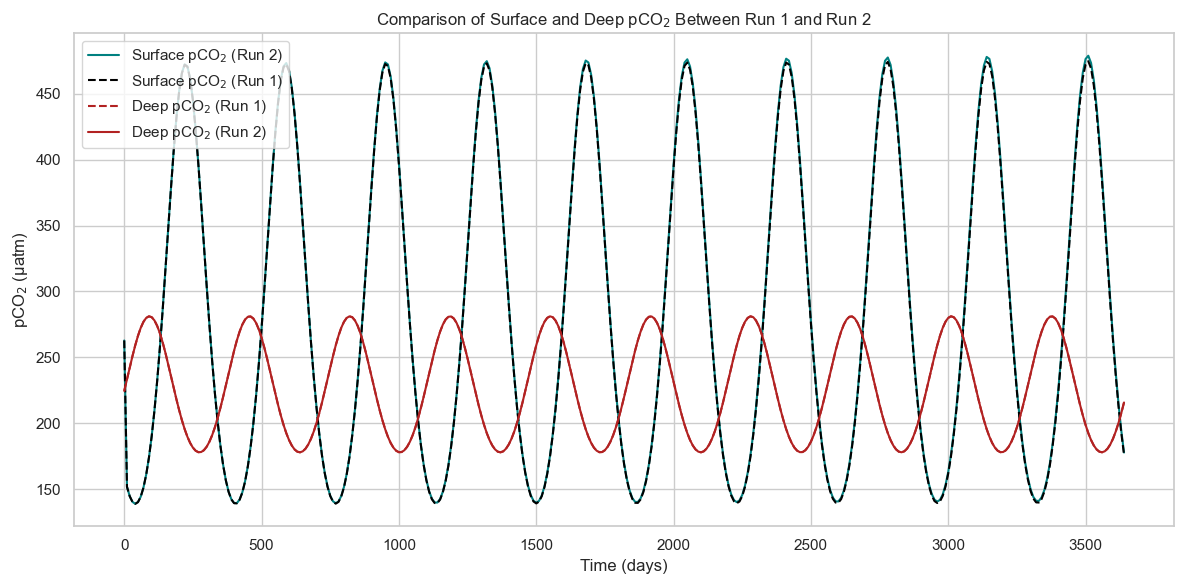

In [85]:
plt.figure(figsize=(12, 6))

# Surface pCO₂
plt.plot(output_df_2['time'], output_df_2['pCO2_surface'], label='Surface pCO$_2$ (Run 2)', color='teal')
plt.plot(output_df_1['time'], output_df_1['pCO2_surface'], label='Surface pCO$_2$ (Run 1)', color='black', linestyle='--')

# Deep pCO₂
plt.plot(output_df_1['time'], output_df_1['pCO2_deep'], label='Deep pCO$_2$ (Run 1)', color='firebrick', linestyle='--')
plt.plot(output_df_2['time'], output_df_2['pCO2_deep'], label='Deep pCO$_2$ (Run 2)', color='firebrick')

plt.xlabel("Time (days)")
plt.ylabel("pCO$_2$ (μatm)")
plt.title("Comparison of Surface and Deep pCO$_2$ Between Run 1 and Run 2")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


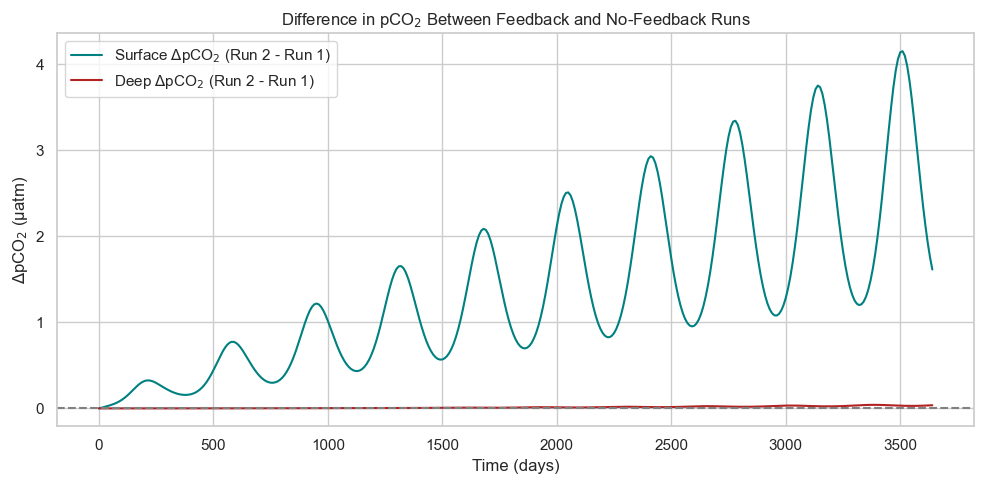

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(output_df_2['time'], output_df_2['pCO2_surface'] - output_df_1['pCO2_surface'], label='Surface ΔpCO$_2$ (Run 2 - Run 1)', color='teal')
plt.plot(output_df_2['time'], output_df_2['pCO2_deep'] - output_df_1['pCO2_deep'], label='Deep ΔpCO$_2$ (Run 2 - Run 1)', color='firebrick')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Time (days)")
plt.ylabel("ΔpCO$_2$ (µatm)")
plt.title("Difference in pCO$_2$ Between Feedback and No-Feedback Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


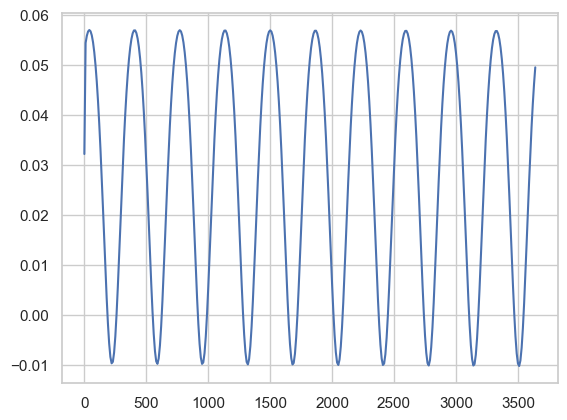

In [81]:
plt.plot(output_df_1['time'], output_df_1['J_air'])
